## Import modules

In [1]:
import numpy as np
import open3d as o3d
from sklearn.ensemble import RandomForestClassifier
import pdal
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plyfile import PlyData, PlyElement
import gc
from itertools import chain
from sklearn.metrics import confusion_matrix
import gc
import joblib # Use to save model
from datetime import datetime, timezone
sns.set()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# ROOT_PLY = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/L001.ply"""

## Load in features

In [3]:
ROOT  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_10_23T22_14_L001_r_0_1_grid_0_02_features.npz"""
ROOT_2  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_10_23T23_39_L001_r_0_2_grid_0_04_features.npz"""
ROOT_3  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_10_24T05_30_L001_r_0_4_grid_0_08_features.npz"""
ROOT_4  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_10_24T11_50_L001_r_0_8_grid_0_16_features.npz"""
ROOT_5  = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_10_24T12_27_L001_r_1_6_grid_0_32_features.npz"""
ROOT_6 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/training/radial/2025_10_24T20_28_L001_r_3_2_grid_0_64_features.npz"""
# ROOT_7 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_28T00_29_L001_r_6_4_grid_1_28_features.npz"""
# ROOT_8 = """/home/sspiegel/CapstoneData/Paris/Toronto_3D/pickleFiles/2025_10_28T01_37_L001_r_12_8_grid_2_56_features.npz"""


In [4]:
fileList = [ROOT,ROOT_2, ROOT_3,ROOT_4,ROOT_5, ROOT_6]

## Get computed features

In [5]:
das = [np.load(r)["array2"] for r in fileList]
das = np.hstack(das)

## Load in points and labels

In [6]:
xyz = np.load(fileList[0])["array1"]

cls = np.load(fileList[0])["array3"]

## Combine road markings with Ground points

In [7]:
cls[cls==2] = 1

In [8]:
cls[cls > 1] -= 1

## Get columns

In [9]:
cols = ["EigenSum","omnivariance","entropy","linearity","planarity","sphericity","curvature","verticality1","verticality2","count"]

In [10]:
# cols1 = [f"""{a}_radius1""" for a in cols]
# cols2 = [f"""{a}_radius2""" for a in cols]
ff = []

for i in range(1, len(fileList) + 1):
    col = [f"""{a}_radius{i}""" for a in cols]
    ff += col
    

# allCols = cols1 + cols2
    
    
    

In [11]:
allCols = ['X', 'Y','Z'] + ff + ['label']

In [12]:
allAtrs = np.hstack((xyz,das, cls.reshape(-1, 1)))

## Create dataframe

In [13]:
total_dataframe = pd.DataFrame(allAtrs, columns=allCols)
total_dataframe["label"] = total_dataframe["label"].astype(int)
for i in range(1, len(fileList) + 1):
    total_dataframe[f"""count_radius{i}"""] = total_dataframe[f"""count_radius{i}"""].astype(int)
# total_dataframe["count_radius1"] = total_dataframe["count_radius1"].astype(int)
# total_dataframe["count_radius2"] = total_dataframe["count_radius2"].astype(int)

# total_dataframe["labelName"] = total_dataframe["label"].apply(labelPoints)

In [14]:
total_dataframe = total_dataframe.query("label != 0") # We are not going to train on unclassified points
total_dataframe = total_dataframe.copy()

In [15]:
gc.collect()

11

In [16]:
# ss = ss[ss["count"] > 10]

## Create PLY files with features (Only do if they don't already exist)

In [17]:
# for i in range(1, 7):
#     ls = [col for col in list(total_dataframe) if col.endswith(f"""radius{i}""")]
#     ls = ['X','Y','Z'] + ls + ['label']
#     partial_df = total_dataframe[ls]

#     tpsOut = []
#     for idx, tpe in partial_df.dtypes.to_dict().items():
#         if tpe == 'int64':
#             tpsOut.append((idx, 'i4'))
#         elif tpe == 'float64':
#             tpsOut.append((idx, 'f8'))
            
#     vertex_data = np.empty(allAtrs.shape[0], dtype=tpsOut)
    
#     for t in tpsOut:
#         vertex_data[t[0]] = partial_df[t[0]].values
    
        
#     el = PlyElement.describe(vertex_data, 'vertex')
    
#     # Create a PlyData object and write to a PLY file
#     # Set text=True for ASCII PLY, or text=False for binary PLY
#     PlyData([el], text=False).write(f"""/home/sspiegel/CapstoneData/Paris/Toronto_3D/PC_with_features/L001_features_radius{i}.ply""")

## Instantiate Random Forest classifier

In [18]:
rf = RandomForestClassifier(verbose=1, n_jobs=16)

In [19]:
rf

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
total_dataframe.reset_index(inplace = True)

### Take random samples of labels for training data

In [21]:
maxAcc = 0.0

AccList = [maxAcc]

AccDelta = 1e-4

difDelta = np.inf


randomState = 123
sampleSize = 1000

iters = 0


idsTrained = []

RemainTest = total_dataframe.copy()

while (difDelta >= AccDelta) and ( iters < 50):
    # print(sampleSize)
    print("""Starting iteration %d...""" % (iters + 1))
    TrainList = []
    idsList = []

    for i in range(1,8):
    #     if iters > 0: # Change sampling size after initial sample is given
    #         sampleSize = 1000
        print(f"""Label {i}""")
        SelectList = RemainTest.loc[RemainTest["label"] == i]
        SelectList = SelectList.copy()
        trns = SelectList.sample(n = sampleSize, random_state = randomState)
        idsList.append(trns.index.to_list())
        
        TrainList.append(trns)
    idsList = list(chain.from_iterable(idsList))
    idsTrained += idsList

    TrainList = total_dataframe.loc[idsTrained]

    # TrainList = pd.concat(TrainList)
    
    TrainList = TrainList.sample(frac = 1., random_state = randomState)
    
    TrainListX = TrainList[ff]
    TrainListY = TrainList["label"]
        
    rf.fit(TrainListX, TrainListY)
    
        
    RemainTestX = RemainTest[ff]
    RemainTestY = RemainTest["label"]
    
    RemainTest = RemainTest.loc[~RemainTest["index"].isin(idsTrained)]
    
    
    yPred = rf.predict(RemainTestX)
        
    RemainTestSample = RemainTest.sample(frac = 0.1, random_state=randomState)
    RemainTestSampleX = RemainTestSample[ff]
    RemainTestSampleY = RemainTestSample["label"]
    
    yPredSample = rf.predict(RemainTestSampleX)
    acc = (yPredSample==RemainTestSampleY).sum() / RemainTestSampleY.shape[0]

    print("""Current accuracy: %.4f""" % (100*acc))
    AccList.append(acc)

    difDelta = np.abs(maxAcc - acc)

    print("""\n\nCurrent accuracy delta: %.5f""" % difDelta)
    
    if acc > maxAcc:
        maxAcc = acc
    

    iters += 1

    # idsTrained += idsList  
    gc.collect()

print("""DONE!!!!""")   

    
    
    
    
    # print(total_dataframe.loc[total_dataframe["label"] == i].shape[0])

Starting iteration 1...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    7.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   27.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.3s finished


Current accuracy: 94.4802


Current accuracy delta: 0.94480
Starting iteration 2...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   28.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.5s finished


Current accuracy: 95.2445


Current accuracy delta: 0.00764
Starting iteration 3...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   29.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.7s finished


Current accuracy: 95.8382


Current accuracy delta: 0.00594
Starting iteration 4...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   29.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.8s finished


Current accuracy: 96.1150


Current accuracy delta: 0.00277
Starting iteration 5...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   28.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.9s finished


Current accuracy: 96.3643


Current accuracy delta: 0.00249
Starting iteration 6...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.0s finished


Current accuracy: 96.4760


Current accuracy delta: 0.00112
Starting iteration 7...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   29.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.1s finished


Current accuracy: 96.6433


Current accuracy delta: 0.00167
Starting iteration 8...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   28.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.1s finished


Current accuracy: 96.8008


Current accuracy delta: 0.00158
Starting iteration 9...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   28.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.0s finished


Current accuracy: 96.8886


Current accuracy delta: 0.00088
Starting iteration 10...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   31.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.9s finished


Current accuracy: 97.0242


Current accuracy delta: 0.00136
Starting iteration 11...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.3s finished


Current accuracy: 97.1104


Current accuracy delta: 0.00086
Starting iteration 12...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.1s finished


Current accuracy: 97.1425


Current accuracy delta: 0.00032
Starting iteration 13...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    8.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   29.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.2s finished


Current accuracy: 97.2709


Current accuracy delta: 0.00128
Starting iteration 14...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   10.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.3s finished


Current accuracy: 97.2890


Current accuracy delta: 0.00018
Starting iteration 15...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   10.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   31.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.4s finished


Current accuracy: 97.3401


Current accuracy delta: 0.00051
Starting iteration 16...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   11.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   29.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.2s finished


Current accuracy: 97.4336


Current accuracy delta: 0.00093
Starting iteration 17...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.5s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   11.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   29.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.3s finished


Current accuracy: 97.4956


Current accuracy delta: 0.00062
Starting iteration 18...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.7s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   12.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   28.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.4s finished


Current accuracy: 97.5437


Current accuracy delta: 0.00048
Starting iteration 19...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.6s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.5s finished


Current accuracy: 97.5722


Current accuracy delta: 0.00029
Starting iteration 20...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   14.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   31.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.4s finished


Current accuracy: 97.6262


Current accuracy delta: 0.00054
Starting iteration 21...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   15.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   31.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.5s finished


Current accuracy: 97.6502


Current accuracy delta: 0.00024
Starting iteration 22...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   16.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.4s finished


Current accuracy: 97.6881


Current accuracy delta: 0.00038
Starting iteration 23...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   16.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   31.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.4s finished


Current accuracy: 97.7389


Current accuracy delta: 0.00051
Starting iteration 24...
Label 1
Label 2
Label 3
Label 4
Label 5
Label 6
Label 7


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   17.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    9.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:   30.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    4.6s finished


Current accuracy: 97.7323


Current accuracy delta: 0.00007
DONE!!!!


In [22]:
gc.collect()

0

## Plot iterations and accuracy

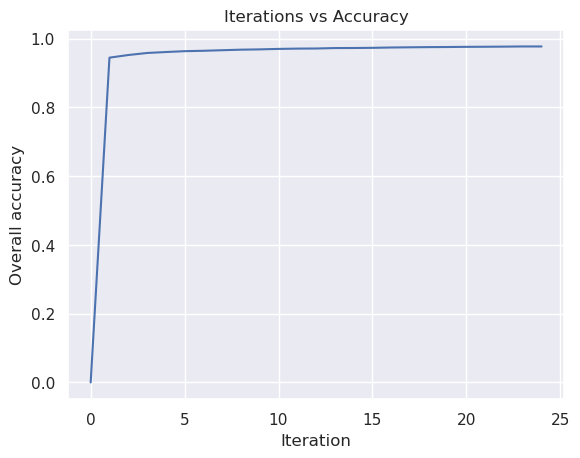

In [23]:
plt.plot(AccList)

plt.xlabel("Iteration")
plt.ylabel("Overall accuracy")

plt.title("Iterations vs Accuracy")

plt.show()


## Output model

In [24]:
OUTS = f"""{datetime.now().strftime("%Y_%m_%d")}_Trained_radial_RF.joblib"""

joblib.dump(rf, f"""/home/sspiegel/CapstoneData/Paris/RF_models/{OUTS}""")

['/home/sspiegel/CapstoneData/Paris/RF_models/2025_11_05_Trained_radial_RF.joblib']